## Use full data from Odyssey

In [1034]:
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mat', 'diff', 'f', 'beta', 'power', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [824]:
binfile = '/mnt/store1/oliverphilcox/PowerSpectra/k_binning_R0_50.csv'
counts_dir = '/mnt/store1/oliverphilcox/PowerQPM_New/R0_50_small/'
#counts_dir1 = '/mnt/store1/oliverphilcox/PowerQPM50/'
#counts_dir2 = '/mnt/store1/oliverphilcox/PowerQPM50_noPhi/'
n = 9
l = 4
m = l//2+1

### Load in counts

In [825]:
k_bins = np.loadtxt(binfile).mean(axis=1)
all_k = np.loadtxt(binfile)

In [826]:
RR = np.zeros([n,m])
index = 0
while True:
    filename = counts_dir+'RR_%d_power_counts_n%d_m%d_full.txt'%(index,n,m)
    if not os.path.exists(filename):
        break
    RR+=np.loadtxt(filename)
    index+=1

In [827]:
DD = np.loadtxt(counts_dir+'DD_mock_0001_power_counts_n%d_m%d_full.txt'%(n,m))
DR = np.loadtxt(counts_dir+'DR_mock_0001_power_counts_n%d_m%d_full.txt'%(n,m))

In [828]:
### count number of random particles
rand_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_randoms_50x.xyzwj'
with open(rand_par) as infile:
    for l,line in enumerate(infile):
        pass
N_rand = l+1

In [829]:
### count number of galaxies
gal_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_galaxy_1.xyzwj'
with open(gal_par) as infile:
    for l,line in enumerate(infile):
        pass
N_gal=l+1

In [198]:
### count number of randoms
index = 0.
RR_pairs = 0.
while True:
    this_rand_par = '/mnt/store1/oliverphilcox/PowerSpectra/qpm_randoms_50x_%d'%index
    if not os.path.exists(this_rand_par):
        break
    with open(this_rand_par) as infile:
        for l,line in enumerate(infile):
            pass
    RR_pairs+=(l+1)*l
    index+=1

In [1064]:
DR_pairs = N_gal*N_rand
DD_pairs = N_gal*(N_gal-1)

In [1065]:
norm = 0
with open(gal_par) as infile:
    for l,line in enumerate(infile):
        this_w = float(line.split()[3])
        norm+=this_w**2.*(1./this_w-1.)/20000
print("Norm = %.2f"%norm)

Norm = 4.25


In [1066]:
### compute power
power = (DD-2.*DR/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm
#power_noPhi = (DDnoPhi-2.*DRnoPhi/(DR_pairs/DD_pairs)+RRnoPhi/(RR_pairs/DD_pairs))/(norm*N_gal/N_rand)

In [267]:
all_DD=[]
all_DR=[]
good_mocks=[]
n_mocks=0
for mock_int in range(1,301):
    mock_no = str(mock_int).zfill(4)
    z=int(mock_no)
    if(z==129)or(z==138)or(z==140):
        continue
    if os.path.exists(counts_dir+'DD_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m)):
        if os.path.exists(counts_dir+'DR_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m)):
            tDD = np.loadtxt(counts_dir+'DD_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m))
            tDR = np.loadtxt(counts_dir+'DR_mock_%s_power_counts_n%d_m%d_full.txt'%(mock_no,n,m))
            all_DD.append(tDD)
            all_DR.append(tDR)
            n_mocks+=1
            good_mocks.append(mock_no)

In [274]:
### count number of galaxies in each file
N_gal_all=[]
norm_all=[]
for mock_no in good_mocks:
    ### count number of galaxies
    gal_par = '/mnt/store1/oliverphilcox/QPM_proc/qpm_galaxy_%s.xyzw'%mock_no
    this_norm=0.
    with open(gal_par) as infile:
        for l,line in enumerate(infile):
            this_w = float(line.split()[3])
            this_norm+=this_w**2.*(1./this_w-1.)/20000
    N_gal_all.append(l+1)
    norm_all.append(this_norm)

In [928]:
all_power = []
pow_mean,pow_std = [np.zeros([n,m]) for _ in range(2)]
for i in range(n_mocks):
    DR_pairs = N_gal_all[i]*N_rand
    DD_pairs = N_gal_all[i]*(N_gal_all[i]-1)
    all_power.append((all_DD[i]-2.*all_DR[i]/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm_all[i])
for i in range(n):
    for j in range(m):
        pow_mean[i,j] = np.mean([all_power[ind][i,j] for ind in range(n_mocks)])
        pow_std[i,j] = np.std([all_power[ind][i,j] for ind in range(n_mocks)])

#### Load R0=100 power

In [929]:
power100 = np.load('R0_100_power.npy')
k100 = np.loadtxt('/mnt/store1/oliverphilcox/PowerSpectra/k_binning2.csv').mean(axis=1)

#### Load no Phi power

In [930]:
power50_noPhi = np.load('R0_50_no_phi_power.npy')
power100_noPhi = np.load('R0_100_no_phi_power.npy')

#### Define Covariance

In [931]:
power_ravel = np.asarray([pp.reshape(n,m).T.ravel() for pp in all_power])
qpm_cov = np.zeros([len(all_power[0].ravel()),len(all_power[0].ravel())])
power_mean = power_ravel.mean(axis=0)
for i in range(len(good_mocks)):
    tmp = all_power[i].T.ravel().reshape(-1,1)-power_mean.reshape(-1,1)
    qpm_cov+=np.matmul(tmp,tmp.T)
qpm_cov/=len(good_mocks)-1

In [932]:
qpm_std = (np.diag(qpm_cov)**0.5).reshape(m,n).T

In [933]:
np.save('R0_50_cov.npy',qpm_cov)

#### Load R0=100 Covariance

In [934]:
qpm_cov100 = np.load('R0_100_cov.npy')
m100=m
n100=19
qpm_std100 = (np.diag(qpm_cov100)**0.5).reshape(m100,n100).T

#### Load CAMB model

In [1078]:
camb_dir = np.load('/mnt/store1/oliverphilcox/PowerSpectra/CAMB_power_QPM.npz')
camb_k_all = camb_dir['k']
camb_k = camb_k_all[camb_k_all>0.01]
camb_Pk = camb_dir['linear_power'][camb_k_all>0.01]
camb_Pk_NL = camb_dir['non_linear_power'][camb_k_all>0.01]


from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log10(camb_k),np.log10(camb_Pk))
spl_NL = UnivariateSpline(np.log10(camb_k),np.log10(camb_Pk_NL))

f = 0.774 # kaiser power
b = 2 # bias
beta = f/b

In [1079]:
def no_FoG_multipole_analyt(ell,k,beta=beta,b=b,NL=False):
    if NL:
        this_pow = 10.**spl_NL(np.log10(k))
    else:
        this_pow = 10.**spl(np.log10(k))
    if ell==0:
        return this_pow*b**2*(1+2*beta/3+beta**2/5)
    elif ell==2:
        return this_pow*b**2*4./21.*beta*(7.+3*beta)
    elif ell==4:
        return this_pow*b**2*8*beta**2/35
def FoG_multipole_analyt(ell,k,sigma=1,beta=beta,b=b,NL=False):
    """ Using expression from Percival/White09 with Eq.21 with Lorentzian FoG.
    Calculations done in Mathematica (or 1610.07785.)"""
    if NL:
        this_pow = 10.**spl_NL(np.log10(k))
    else:
        this_pow = 10.**spl(np.log10(k))
    if ell==0:
        return this_pow*b**2*(beta*k*sigma*(-3*beta + (6 + beta)*k**2*sigma**2) + 3*(beta - k**2*sigma**2)**2*np.arctan(k*sigma))/(3.*k**5*sigma**5)
    if ell==2:
        return this_pow*b**2*(45*beta**2*k*sigma - 90*beta*k**3*sigma**3 + (45 + 4*beta**2)*k**5*sigma**5 - 15*(beta - k**2*sigma**2)**2*(3 + k**2*sigma**2)*np.arctan(k*sigma))/(6.*k**7*sigma**7)
    if ell==4:
        return this_pow*b**2*(3*(beta - k**2*sigma**2)**2*(-5*k*sigma*(21 + 11*k**2*sigma**2) + 3*(35 + 30*k**2*sigma**2 + 3*k**4*sigma**4)*np.arctan(k*sigma)))/(8.*k**9*sigma**9)

## Plots

Using 10x errors


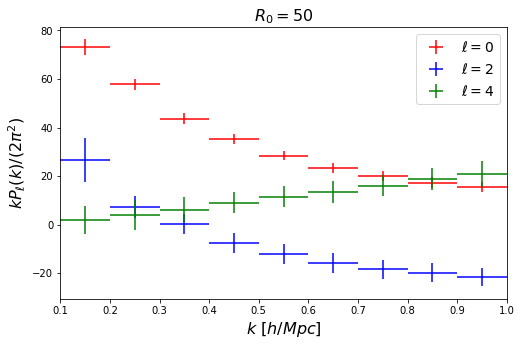

In [937]:
plt.figure(figsize=(8,5))
plt.errorbar(k_bins,k_bins*power[:,0]/(2*np.pi**2),k_bins*qpm_std[:,0]/(2.*np.pi**2.)*10,0.05,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,k_bins*power[:,1]/(2.*np.pi**2.),k_bins*qpm_std[:,1]/(2.*np.pi**2.)*10,0.05,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,k_bins*power[:,2]/(2.*np.pi**2.),k_bins*qpm_std[:,2]/(2.*np.pi**2.)*10,0.05,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$kP_\ell(k)/(2\pi^2)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
plt.legend(fontsize=14);
plt.title(r'$R_0=50$',fontsize=16);
print('Using 10x errors')

Using 10x errors


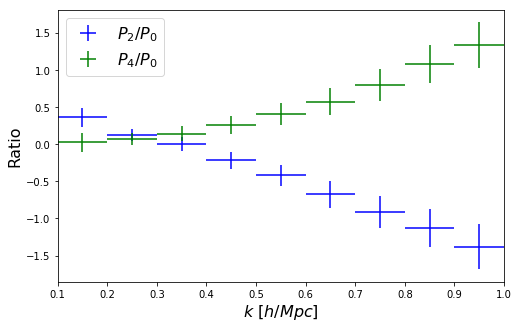

In [938]:
plt.figure(figsize=(8,5))
quad_ratio = power[:,1]/power[:,0]
hex_ratio = power[:,2]/power[:,0]
quad_err = quad_ratio*np.sqrt((qpm_std[:,0]/power[:,0])**2.+(qpm_std[:,1]/power[:,1])**2.)
hex_err = quad_ratio*np.sqrt((qpm_std[:,0]/power[:,0])**2.+(qpm_std[:,1]/power[:,1])**2.)
plt.errorbar(k_bins,quad_ratio,quad_err*10,0.05,marker='',ls='',c='b',label=r'$P_2/P_0$')
plt.errorbar(k_bins,hex_ratio,10*hex_err,0.05,marker='',ls='',c='g',label=r'$P_4/P_0$')
plt.ylabel(r'Ratio',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
#plt.yscale('log')
plt.legend(fontsize=16);
print("Using 10x errors")

## Plot both $R_0=50$ (points) and $R_0=100$ (lines)

Using 10x errors


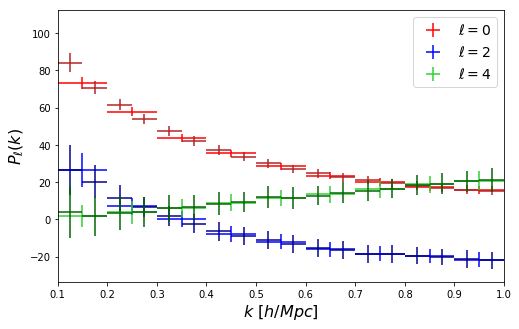

In [939]:
plt.figure(figsize=(8,5))
f=k_bins/(2.*np.pi**2.)
f100 = k100/(2.*np.pi**2)
plt.errorbar(k_bins,f*power[:,0],f*qpm_std[:,0]*10,0.05,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k100,f100*power100[:,0],f100*qpm_std100[:,0]*10,0.025,marker='',ls='',c='firebrick')
plt.errorbar(k_bins,f*power[:,1],f*qpm_std[:,1]*10,0.05,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k100,f100*power100[:,1],f100*qpm_std100[:,1]*10,0.025,marker='',ls='',c='darkblue')
plt.errorbar(k_bins,f*power[:,2],f*qpm_std[:,2]*10,0.05,marker='',ls='',c='limegreen',label=r'$\ell = 4$')
plt.errorbar(k100,f100*power100[:,2],f100*qpm_std100[:,2]*10,0.025,marker='',ls='',c='darkgreen')
plt.ylabel(r'$P_\ell(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
plt.legend(fontsize=14);
print('Using 10x errors')

In [940]:
np.savez('plot_data/full_power_plots.npz',k_bins=k_bins,k100=k100,power=power,power100=power100,qpm_std=qpm_std,
        qpm_std100=qpm_std100)

Using 10x errors


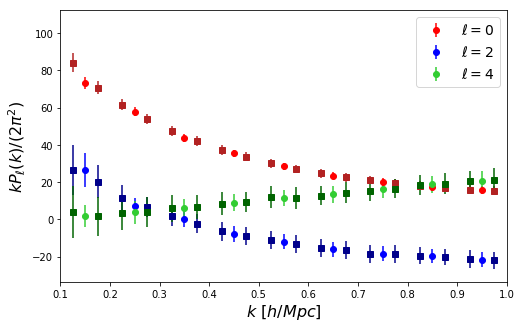

In [941]:
plt.figure(figsize=(8,5))
f=k_bins/(2.*np.pi**2.)
f100 = k100/(2.*np.pi**2)
plt.errorbar(k_bins,f*power[:,0],f*qpm_std[:,0]*10,marker='o',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k100,f100*power100[:,0],f100*qpm_std100[:,0]*10,marker='s',ls='',c='firebrick')
plt.errorbar(k_bins,f*power[:,1],f*qpm_std[:,1]*10,marker='o',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k100,f100*power100[:,1],f100*qpm_std100[:,1]*10,marker='s',ls='',c='darkblue')
plt.errorbar(k_bins,f*power[:,2],f*qpm_std[:,2]*10,marker='o',ls='',c='limegreen',label=r'$\ell = 4$')
plt.errorbar(k100,f100*power100[:,2],f100*qpm_std100[:,2]*10,marker='s',ls='',c='darkgreen')
plt.ylabel(r'$kP_\ell(k)/(2\pi^2)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
#plt.ylim([-1000,15000]);
plt.legend(fontsize=14);
print('Using 10x errors')

## Plot Ratio

In [1015]:
power50dat = np.load('R0_50_fine_all.npz')
power100dat = np.load('R0_100_all.npz')

good50 = power50dat.f.good_mocks
good100 = power100dat.f.good_mocks
best_mocks=[]
for i in range(len(good50)):
    if good50[i] in good100:
        best_mocks.append(good50[i])

In [1018]:
cut_pow50,cut_pow100 = [],[]
for i in range(len(good50)):
    if good50[i] in best_mocks:
        cut_pow50.append(power50dat.f.all_power[i])
for i in range(len(good100)):
    if good100[i] in best_mocks:
        cut_pow100.append(power100dat.f.all_power[i])        

In [1019]:
len(best_mocks)

80

In [1020]:
np.savez('plot_data/50-100-ratio.npz',power50=cut_pow50,power100=cut_pow100,k100=k100,)

In [989]:
plt.figure(figsize=(8,5))
err_tot = np.sqrt((qpm_std/power)**2.+(qpm_std100/power100)**2.)*power/power100
plt.errorbar(k_bins,power[:,0]/power100[:,0],err_tot[:,0],0.025,
             marker='',ls=':',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1]/power100[:,1],err_tot[:,1],0.025,
             marker='',ls=':',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power[:,2]/power100[:,2],err_tot[:,2],0.025,
             marker='',ls=':',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k;50)/P_\ell(k;100)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
plt.legend(fontsize=14);

ValueError: operands could not be broadcast together with shapes (9,3) (19,3) 

<Figure size 576x360 with 0 Axes>

## Plot Power without Survey Correction Function $\Phi$

In [943]:
power100.shape

(19, 3)

In [944]:
power50_noPhi.shape

(19, 3)

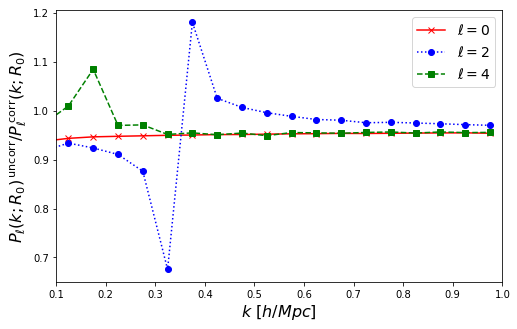

In [945]:
power50 = np.load('R0_50_power_0.05.npy')
plt.figure(figsize=(8,5))
plt.errorbar(k100,power100_noPhi[:,0]/power100[:,0],marker='x',ls='-',c='r',alpha=1,label=r'$\ell = 0$')
plt.errorbar(k100,power100_noPhi[:,1]/power100[:,1],marker='o',ls=':',c='b',alpha=1,label=r'$\ell = 2$')
plt.errorbar(k100,power100_noPhi[:,2]/power100[:,2],marker='s',ls='--',c='g',alpha=1,label=r'$\ell = 4$')

plt.ylabel(r'$P_\ell(k;R_0)^\mathrm{\,uncorr}/P_\ell^\mathrm{\,corr}(k;R_0)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.1,1.])
plt.legend(fontsize=14);
#plt.title(r'$R_0 = 50$ (dotted), $R_0=100$ (full)',fontsize=16);

In [946]:
np.savez('plot_data/no_phi_plots.npz',k100=k100,power100_noPhi=power100_noPhi,power100=power100)

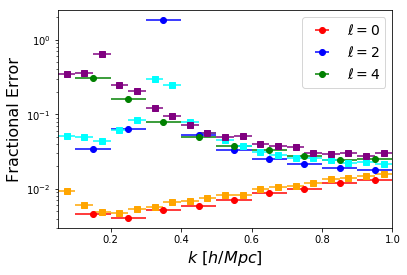

In [947]:
x=np.abs(qpm_std/power)
x100=np.abs(qpm_std100/power100)
plt.errorbar(k_bins,x[:,0],None,0.05,c='r',label=r'$\ell = 0$',ls='',marker='o')
plt.errorbar(k_bins,x[:,1],None,0.05,c='b',label=r'$\ell = 2$',ls='',marker='o')
plt.errorbar(k_bins,x[:,2],None,0.05,c='g',label=r'$\ell = 4$',ls='',marker='o')
plt.errorbar(k100,x100[:,0],None,0.025,ls='',marker='s',c='orange')
plt.errorbar(k100,x100[:,1],None,0.025,ls='',marker='s',c='cyan')
plt.errorbar(k100,x100[:,2],None,0.025,ls='',marker='s',c='purple')
plt.yscale('log');
plt.xlim([0.05,1.])
plt.legend(fontsize=14);
plt.ylabel('Fractional Error',fontsize=16);
plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16);

### Compare to CAMB Kaiser + FoG model

In [1070]:
k_bins

array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [1108]:
def diff(pars,R0=100):
    if R0==100:
        pp=power100
        qq=qpm_std100
        kk=k100
    else:
        pp=power
        qq=qpm_std
        kk=k_bins
    sigma0,beta0,b0=pars
    mod_pow = FoG_multipole_analyt(0,kk,sigma0,beta0,b0,True)
    mod_pow2 = FoG_multipole_analyt(2,kk,sigma0,beta0,b0,True)
    mod_pow4 = FoG_multipole_analyt(4,kk,sigma0,beta0,b0,True)
    out=np.sum(0.5*((mod_pow-pp[:,0])/qq[:,0])**2)
    out+=np.sum(0.5*((mod_pow2-pp[:,1])/qq[:,1])**2)
    out+=np.sum(0.5*((mod_pow4-pp[:,2])/qq[:,2])**2)
    return out
from scipy.optimize import minimize
out=minimize(diff,[4.,beta,b])

In [1107]:
opt_sigmaFoGNL,opt_betaFoGNL,opt_bFoGNL = out.x

In [1109]:
opt_sigmaFoG,opt_betaFoG,opt_bFoG = out.x

In [1098]:
opt_pars = out.x
print(opt_pars)
opt_sigma,opt_beta,opt_b = opt_pars

opt_pars2 = out2.x
print(opt_pars2)
opt_beta2,opt_b2 = opt_pars2

[1.4221095  0.02641421 2.4355764 ]
[-0.20899275  1.8428201 ]


In [1117]:
def diff_no_FoG(pars):
    beta0,b0=pars
    mod_pow = no_FoG_multipole_analyt(0,k_bins,beta0,b0,True)
    mod_pow2 = no_FoG_multipole_analyt(2,k_bins,beta0,b0,True)
    mod_pow4 = no_FoG_multipole_analyt(4,k_bins,beta0,b0,True)
    out=np.sum(0.5*((mod_pow-power[:,0])/qpm_std[:,0])**2)
    out+=np.sum(0.5*((mod_pow2-power[:,1])/qpm_std[:,1])**2)
    out+=np.sum(0.5*((mod_pow4-power[:,2])/qpm_std[:,2])**2)
    return out
from scipy.optimize import minimize
out2=minimize(diff_no_FoG,[beta,b])

In [1114]:
opt_betaNL,opt_bNL = out2.x

In [1116]:
opt_betaFid,opt_bFid = out2.x

In [1143]:
model_power_NL,model_power_NL_FoG,model_power,model_power_FoG = [[] for _ in range(4)]
k_all = np.linspace(0.01,1.,1000)
for m in range(3):
    model_power_NL.append(no_FoG_multipole_analyt(m*2,k_all,opt_beta,opt_b,True))
    model_power_NL_FoG.append(FoG_multipole_analyt(m*2,k_all,opt_sigma,opt_beta,opt_b,True))
    model_power.append(no_FoG_multipole_analyt(m*2,k_all,opt_beta,opt_b,False))
    model_power_FoG.append(FoG_multipole_analyt(m*2,k_all,opt_sigma,opt_beta,opt_b,False))

In [1145]:
model_power_NL,model_power_NL_FoG,model_power,model_power_FoG,model_power_NL_FoG_2 = [[] for _ in range(5)]
k_all = np.linspace(0.0001,1.,100)
for m in range(3):
    model_power_NL.append(no_FoG_multipole_analyt(m*2,k_all,betaQPM,bQPM,True))
    model_power_NL_FoG.append(FoG_multipole_analyt(m*2,k_all,sigmaQPM,betaQPM,bQPM,True))
    model_power.append(no_FoG_multipole_analyt(m*2,k_all,betaQPM,bQPM,False))
    model_power_FoG.append(FoG_multipole_analyt(m*2,k_all,sigmaQPM,betaQPM,bQPM,False))
    model_power_NL_FoG_2.append(FoG_multipole_analyt(m*2,k_all,opt_sigmaFoGNL,opt_betaFoGNL,opt_bFoGNL,True))

In [1146]:
np.savez('plot_data/FoG_model_plot.npz',k_bins=k_bins,power=power,model_power=model_power,
         model_power_FoG=model_power_FoG,model_power_NL = model_power_NL,model_power_NL_FoG=model_power_NL_FoG,
         pow_std = pow_std,k_all=k_all,model_power_NL_FoG_2=model_power_NL_FoG_2)

In [1088]:
model_power_NL_fisher = 10.**spl_NL(np.log10(k100))
np.savez('plot_data/NL_fisher_power100.npz',k_bins=k100,power_NL=model_power_NL_fisher)

In [1089]:
model_power_NL_fisher = 10.**spl_NL(np.log10(k_bins))
np.savez('plot_data/NL_fisher_power50.npz',k_bins=k_bins,power_NL=model_power_NL_fisher)

In [1126]:
bQPM,betaQPM,sigmaQPM = [1.218/0.7,0.445/0.7,3.35]

In [1142]:
sigmaQPM

3.35

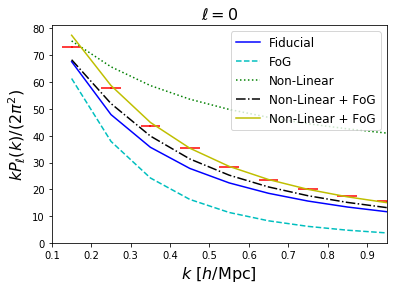

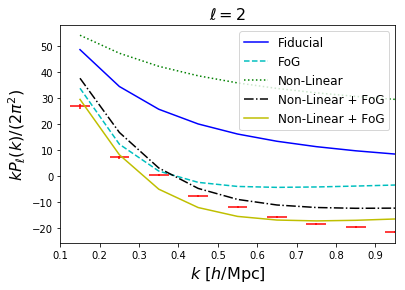

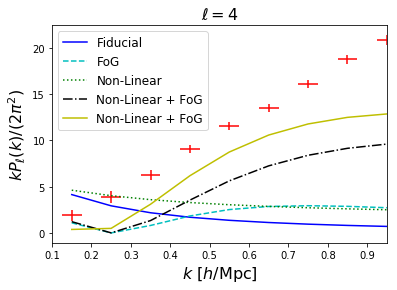

In [1133]:
for m in range(3):
    plt.figure()
    
#     model_power_NL = no_FoG_multipole_analyt(m*2,k_bins,opt_betaNL,opt_bNL,True)
    model_power_NL_FoG_2 = FoG_multipole_analyt(m*2,k_bins,opt_sigmaFoGNL,opt_betaFoGNL,opt_bFoGNL,True)
#     model_power = no_FoG_multipole_analyt(m*2,k_bins,opt_betaFid,opt_bFid,False)
#    model_power_FoG = FoG_multipole_analyt(m*2,k_bins,opt_sigmaFoG,opt_betaFoG,opt_bFoG,False)

    model_power_NL = no_FoG_multipole_analyt(m*2,k_bins,betaQPM,bQPM,True)
    model_power_NL_FoG = FoG_multipole_analyt(m*2,k_bins,sigmaQPM,betaQPM,bQPM,True)
    model_power = no_FoG_multipole_analyt(m*2,k_bins,betaQPM,bQPM,False)
    model_power_FoG = FoG_multipole_analyt(m*2,k_bins,sigmaQPM,betaQPM,bQPM,False)

    
    plt.errorbar(k_bins,k_bins*power[:,m]/(2.*np.pi**2),xerr=0.025,yerr=k_bins*pow_std[:,m]/(2.*np.pi**2),marker='',ls='',c='r')
    plt.errorbar(k_bins,k_bins*model_power/(2.*np.pi**2),ls='-',label='Fiducial',c='b')
    plt.errorbar(k_bins,k_bins*model_power_FoG/(2.*np.pi**2),ls='--',label='FoG',c='c')
    plt.errorbar(k_bins,k_bins*model_power_NL/(2.*np.pi**2),ls=':',label='Non-Linear',c='g')
    plt.errorbar(k_bins,k_bins*model_power_NL_FoG/(2.*np.pi**2),ls='-.',label='Non-Linear + FoG',c='k')
    plt.errorbar(k_bins,k_bins*model_power_NL_FoG_2/(2.*np.pi**2),ls='-',label='Non-Linear + FoG',c='y')
    
    plt.title(r'$\ell = %d$'%(m*2),fontsize=16)
    plt.ylabel(r'$kP_\ell(k)/(2\pi^2)$',fontsize=16);
    plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16);
    plt.legend(fontsize=12);
    plt.xlim([0.1,0.95])
    #plt.ylim([0.,100.]);

In [1119]:
opt_sigma,opt_beta,opt_b

(1.422109499649713, 0.026414213552480324, 2.4355764008814718)

(0.9, 1.1)

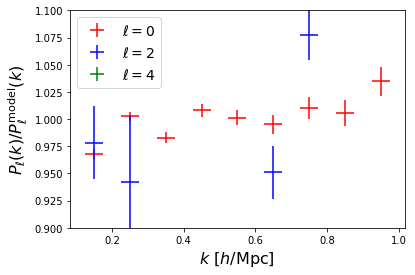

In [955]:
model_power0 = FoG_multipole_analyt(0,k_bins,opt_sigma,opt_beta,opt_b,True)
model_power2 = FoG_multipole_analyt(2,k_bins,opt_sigma,opt_beta,opt_b,True)
model_power4 = FoG_multipole_analyt(4,k_bins,opt_sigma,opt_beta,opt_b,True)

plt.errorbar(k_bins,power[:,0]/model_power0,xerr=0.025,
             yerr=pow_std[:,0]/model_power0,marker='',ls='',c='r',label=r'$\ell = 0$')
plt.errorbar(k_bins,power[:,1]/model_power2,xerr=0.025,
            yerr=pow_std[:,1]/model_power2,marker='',ls='',c='b',label=r'$\ell = 2$')
plt.errorbar(k_bins,power[:,2]/model_power4,xerr=0.025,
             yerr=pow_std[:,2]/model_power4,marker='',ls='',c='g',label=r'$\ell = 4$')
plt.ylabel(r'$P_\ell(k)/P_\ell^\mathrm{model}(k)$',fontsize=16);
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16);
plt.legend(fontsize=14);
#plt.xlim([0.1,.5])
#plt.ylim([0.5,1.5]);
plt.ylim([0.9,1.1])

## Plot Covariance Matrix

In [956]:
k_all = np.concatenate([k_bins for _ in range(3)])
k_mat = np.matmul(k_all.reshape(-1,1),k_all.reshape(1,-1))

k_all100 = np.concatenate([k100 for _ in range(3)])
k_mat100 = np.matmul(k_all100.reshape(-1,1),k_all100.reshape(1,-1))

In [1147]:
nk50 = len(k_bins)
nk100 = len(k100)
m=3
k_med = k_bins
def k_plotter(mat,perc=99.9,title='',vmax=-10,size100=False):
    if size100:
        nk=nk100
    else:
        nk=nk50
    if vmax==-10:
        vmax=np.percentile(mat.ravel(),perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.gca().xaxis.tick_bottom()
    for i in range(m-1):
        plt.hlines(nk*(i+1)-0.5,0,nk*m,linestyles='--',alpha=0.3);
        plt.vlines(nk*(i+1)-0.5,0,nk*m,linestyles='--',alpha=0.3);
    for i in range(m):
        for j in range(m):
            plt.text((i+0.05)*nk,(j+0.8)*nk,'%d%d'%(2*i,2*j),alpha=0.7)
    if len(title)>0:
        plt.title(title,fontsize=16)
    plt.colorbar();    
    ticks = np.concatenate([["%.2f"%(min(k_med)),"%.2f"%(k_med[len(k_med)//2])] for _ in range(m)])
    plt.xticks(np.arange(0,(nk+0.5)*m,nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]))
    plt.yticks(np.arange(0,(nk+0.5)*m,nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]))
    plt.ylim([m*nk-0.5,-0.5])
    plt.xlim([-0.5,m*nk-0.5])
    plt.xlabel(r'$k_a\,\,[h/\mathrm{Mpc}]$',fontsize=14)
    plt.ylabel(r'$k_b\,\,[h/\mathrm{Mpc}]$',fontsize=14)

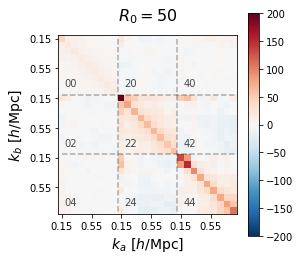

In [1148]:
k_plotter(qpm_cov*k_mat,title=r'$R_0=50$',vmax=200);

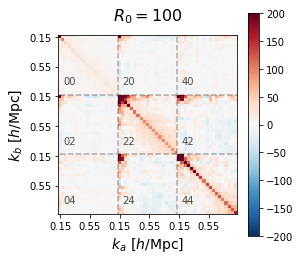

In [1149]:
k_plotter(qpm_cov100*k_mat100,title=r'$R_0=100$',vmax=200,size100=True)#,vmax=1050);

## Correlation Matrices

In [1150]:
def corr_mat(mat):
    out_mat = np.zeros_like(mat)
    for i in range(len(mat)):
        for j in range(len(mat)):
            out_mat[i,j]=mat[i,j]/np.sqrt(mat[i,i]*mat[j,j])
    return out_mat

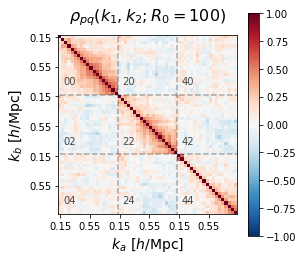

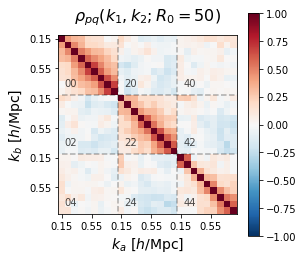

In [1151]:
k_plotter(corr_mat(qpm_cov100),size100=True,title=r'$\rho_{pq}(k_1,k_2;R_0=100)$')
k_plotter(corr_mat(qpm_cov),size100=False,title=r'$\rho_{pq}(k_1,k_2;R_0=50)$')

In [962]:
np.savez('plot_data/corr_mats.npz',corr100 = corr_mat(qpm_cov100),corr50 = corr_mat(qpm_cov))

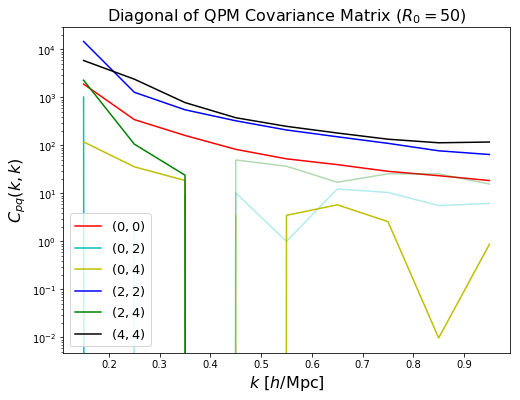

In [963]:
c=['r','c','y','b','g','k']
ci=0
plt.figure(figsize=(8,6))
for i in range(m):
    for j in range(i,m):
        col=c[ci]
        ci+=1
        plt.plot(k_bins,np.diag(qpm_cov[i*n:(i+1)*n,j*n:(j+1)*n]),label=r'$(%d,%d)$'%(i*2,j*2),c=col)
        plt.plot(k_bins,-np.diag(qpm_cov[i*n:(i+1)*n,j*n:(j+1)*n]),alpha=0.3,c=col)
plt.legend(fontsize=13)
plt.ylabel(r'$C_{pq}(k,k)$',fontsize=16)
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16)
plt.title(r'Diagonal of QPM Covariance Matrix ($R_0=50$)',fontsize=16);
plt.yscale('log');

#### Compare two diagonals

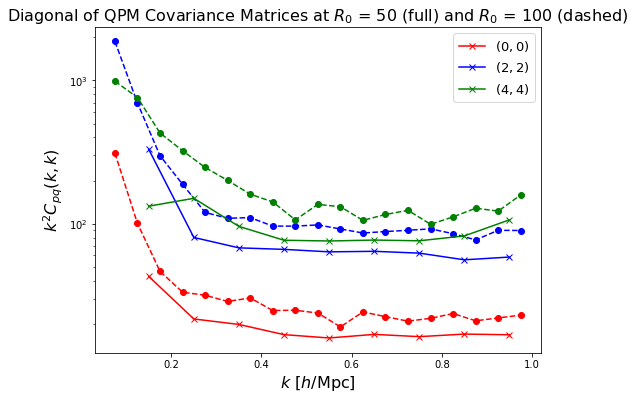

In [964]:
c=['r','b','g']
ci=0
n100=len(k100)
plt.figure(figsize=(8,6))
for i in range(m):
        j=i
        col=c[ci]
        ci+=1
        plt.errorbar(k_bins,k_bins**2*np.diag(qpm_cov[i*n:(i+1)*n,j*n:(j+1)*n]),marker='x',
                     label=r'$(%d,%d)$'%(i*2,j*2),c=col)
        plt.errorbar(k100,k100**2*np.diag(qpm_cov100[i*n100:(i+1)*n100,j*n100:(j+1)*n100]),marker='o',
                     ls='--',c=col)
plt.legend(fontsize=13)
plt.ylabel(r'$k^2C_{pq}(k,k)$',fontsize=16)
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16)
plt.title(r'Diagonal of QPM Covariance Matrices at $R_0$ = 50 (full) and $R_0$ = 100 (dashed)',fontsize=16);
plt.yscale('log');

### Compute inverse matrix (with Hartlap rescaling)

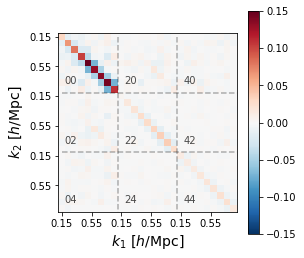

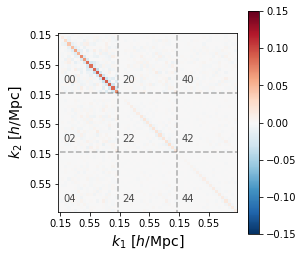

In [965]:
n_mocks_50 = len(good_mocks)
n_mocks_100 = np.load('R0_100_n_mocks.npy')
D_50 = (len(qpm_cov)+1)/(n_mocks_50-1)
D_100 = (len(qpm_cov100)+1)/(n_mocks_100-1)
psi_50 = np.linalg.inv(qpm_cov)/k_mat*(1-D_50)
psi_100 = np.linalg.inv(qpm_cov100)/k_mat100*(1-D_100)
k_plotter(psi_50,vmax=0.15);
k_plotter(psi_100,vmax=0.15,size100=True);

In [966]:
np.savez('plot_data/inv_mats.npz',psi_50=psi_50,psi_100=psi_100)

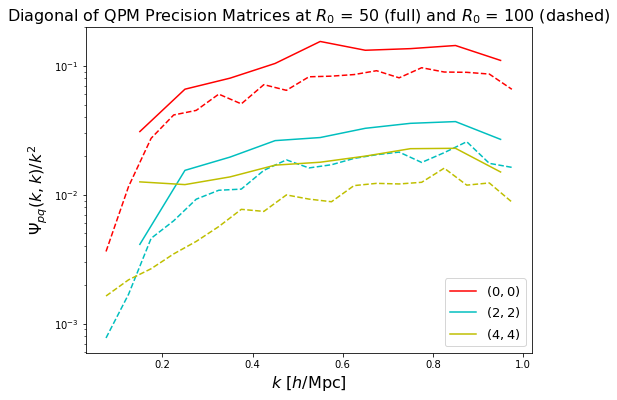

In [967]:
c=['r','c','y','b','g','k']
ci=0
n100=len(k100)
plt.figure(figsize=(8,6))
for i in range(m):
        j=i
        col=c[ci]
        ci+=1
        plt.plot(k_bins,np.diag(psi_50[i*n:(i+1)*n,j*n:(j+1)*n]),label=r'$(%d,%d)$'%(i*2,j*2),c=col)
        plt.plot(k100,np.diag(psi_100[i*n100:(i+1)*n100,j*n100:(j+1)*n100]),ls='--',c=col)
plt.legend(fontsize=13)
plt.ylabel(r'$\Psi_{pq}(k,k)/k^2$',fontsize=16)
plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=16)
plt.title(r'Diagonal of QPM Precision Matrices at $R_0$ = 50 (full) and $R_0$ = 100 (dashed)',fontsize=16);
plt.yscale('log');

In [968]:
gaussian_dat = np.load('gaussian_power_tot_50.npz')
gaussian_2pt = gaussian_dat.f.two_point
gaussian_3pt = gaussian_dat.f.three_point
gaussian_4pt = gaussian_dat.f.four_point
gaussian_tot = lambda alpha: gaussian_2pt*alpha**2.+gaussian_3pt*alpha+gaussian_4pt

In [969]:
gaussian_dat100 = np.load('gaussian_power_tot_100.npz')
gaussian_2pt100 = gaussian_dat100.f.two_point
gaussian_3pt100 = gaussian_dat100.f.three_point
gaussian_4pt100 = gaussian_dat100.f.four_point
gaussian_tot100 = lambda alpha: gaussian_2pt100*alpha**2.+gaussian_3pt100*alpha+gaussian_4pt100

## KL Divergences and $\alpha$ fitting

In [970]:
def KL_div(cov,prec):
    slog1 = np.linalg.slogdet(cov)
    slog2 = np.linalg.slogdet(prec)
    if (slog1[0]<1)or(slog2[0]<1):
        return np.inf
    else:
        return 0.5*(np.trace(np.matmul(cov,prec))-slog1[1]-slog2[1]-len(cov))

In [971]:
def minimizer_50(alpha):
    return KL_div(qpm_cov,np.linalg.inv(gaussian_tot(alpha)))
from scipy.optimize import minimize
out=minimize(minimizer_50,1.)
alpha50_opt = out.x

def minimizer_100(alpha):
    return KL_div(qpm_cov100,np.linalg.inv(gaussian_tot100(alpha)))
from scipy.optimize import minimize
out100=minimize(minimizer_100,1.)
alpha100_opt = out100.x

## $R_0 = 50$

In [972]:
g_inv=np.linalg.inv(gaussian_tot(alpha50_opt))
chol_g = np.linalg.cholesky(g_inv)
disc50 = np.matmul(chol_g.T,np.matmul(qpm_cov,chol_g))-np.eye(len(g_inv))

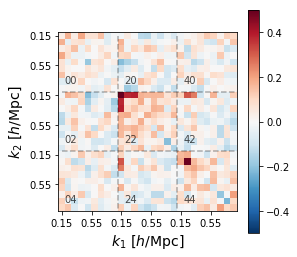

In [973]:
k_plotter(disc50,vmax=0.5)

## $R_0 = 100$

In [1035]:
g_inv100=np.linalg.inv(gaussian_tot100(alpha100_opt))
chol_g = np.linalg.cholesky(g_inv100)
disc100 = np.matmul(chol_g.T,np.matmul(qpm_cov100,chol_g))-np.eye(len(g_inv100))

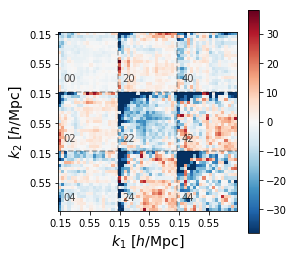

In [1036]:
k_plotter((gaussian_tot100(alpha100_opt)-qpm_cov100)*k_mat100,size100=True)

In [1095]:
np.savez('plot_data/fisher_matrix_precs100.npz',prec_qpm=psi_100*k_mat100,prec_theory=g_inv100)
np.savez('plot_data/fisher_matrix_precs50.npz',prec_qpm=psi_50*k_mat,prec_theory=g_inv)

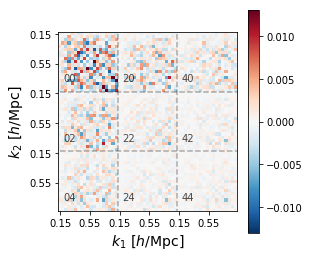

In [1039]:
k_plotter((g_inv100-psi_100*k_mat100)/k_mat100,size100=True)

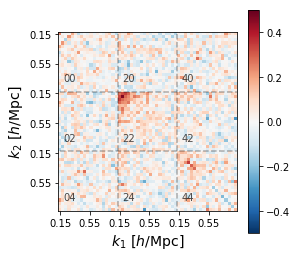

In [1040]:
k_plotter(disc100,vmax=0.5,size100=True)

In [1043]:
np.savez('plot_data/gaussian_comparisons.npz',disc=disc100,diff_prec=(g_inv100-psi_100*k_mat100)/k_mat100,
        alpha_opt = alpha100_opt,trueKL = KL_100, expKL = exp_KL_100)

In [1026]:
KL_100=KL_div(qpm_cov100,g_inv100)
KL_50 = KL_div(qpm_cov,g_inv)

exp_KL_100 = len(qpm_cov100)*(len(qpm_cov100)+1)/(4.*n_mocks_100)
exp_KL_50 = len(qpm_cov)*(len(qpm_cov)+1)/(4.*n_mocks_50)

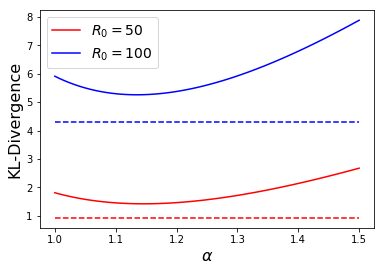

In [1027]:
alphas=np.linspace(1.,1.5,100)
mins = [minimizer_50(a) for a in alphas]
plt.plot(alphas,mins,c='r',label=r'$R_0=50$')
plt.hlines(exp_KL_50,1,1.5,linestyles='--',colors='r')
mins100 = [minimizer_100(a) for a in alphas]
plt.plot(alphas,mins100,c='b',label='$R_0=100$')
plt.hlines(exp_KL_100,1,1.5,linestyles='--',colors='b')
plt.ylabel(r'KL-Divergence',fontsize=16);plt.xlabel(r'$\alpha$',fontsize=16);
plt.legend(fontsize=14);

In [1028]:
print("R0=100: %.2f (True) %.2f (Expected) for alpha = %.2f"%(KL_100,exp_KL_100,alpha50_opt))
print("R0=50: %.2f (True) %.2f (Expected) for alpha = %.2f"%(KL_50,exp_KL_50,alpha100_opt))

R0=100: 5.26 (True) 4.30 (Expected) for alpha = 1.15
R0=50: 1.43 (True) 0.93 (Expected) for alpha = 1.13


## Repeat for only monopole

In [1029]:
def minimizer_50_mon(alpha):
    return KL_div(qpm_cov[:n,:n],np.linalg.inv(gaussian_tot(alpha))[:n,:n])
from scipy.optimize import minimize
out=minimize(minimizer_50_mon,1.)
alpha50_opt_mon = out.x

def minimizer_100_mon(alpha):
    return KL_div(qpm_cov100[:n100,:n100],np.linalg.inv(gaussian_tot100(alpha))[:n100,:n100])
from scipy.optimize import minimize
out100=minimize(minimizer_100_mon,1.)
alpha100_opt_mon = out100.x

In [1030]:
nk50 = len(k_bins)
nk100 = len(k100)
m=3
k_med = k_bins
def k_plotter_mon(mat,perc=99.9,title='',vmax=-10,size100=False):
    if size100:
        nk=nk100
    else:
        nk=nk50
    if vmax==-10:
        vmax=np.percentile(mat.ravel(),perc)
    plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
    plt.gca().xaxis.tick_bottom()
    if len(title)>0:
        plt.title(title,fontsize=16)
    plt.colorbar();    
    ticks = np.concatenate([["%.2f"%(min(k_med)),"%.2f"%(k_med[len(k_med)//2])] for _ in range(1)])
    plt.xticks(np.arange(0,(nk+0.5),nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]))
    plt.yticks(np.arange(0,(nk+0.5),nk/2), np.concatenate([ticks,['%.2f'%max(k_med)]]))
    plt.ylim([nk-0.5,-0.5])
    plt.xlim([-0.5,nk-0.5])
    plt.xlabel(r'$k_1\,\,[h/\mathrm{Mpc}]$',fontsize=14)
    plt.ylabel(r'$k_2\,\,[h/\mathrm{Mpc}]$',fontsize=14)

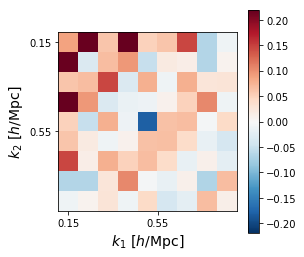

In [1031]:
g_inv_mon=np.linalg.inv(gaussian_tot(alpha50_opt_mon))[:n,:n]
chol_g = np.linalg.cholesky(g_inv_mon)
disc50_mon = np.matmul(chol_g.T,np.matmul(qpm_cov[:n,:n],chol_g))-np.eye(len(g_inv_mon))
k_plotter_mon(disc50_mon);

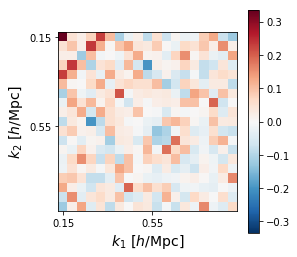

In [1032]:
g_inv_mon100=np.linalg.inv(gaussian_tot100(alpha100_opt_mon))[:n100,:n100]
chol_g = np.linalg.cholesky(g_inv_mon100)
disc100_mon = np.matmul(chol_g.T,np.matmul(qpm_cov100[:n100,:n100],chol_g))-np.eye(len(g_inv_mon100))
k_plotter_mon(disc100_mon,size100=True);

## Plot $C_{00}$ residual for $k>0.1$ at $\alpha=\alpha^*$

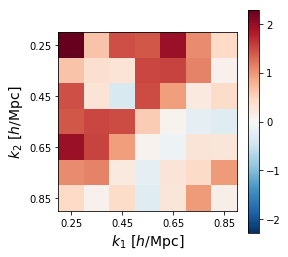

In [1033]:
mat=((qpm_cov-gaussian_tot(alpha50_opt))*k_mat)[2:nk,2:nk]
vmax = np.percentile(mat.ravel(),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();
vals = np.linspace(0,nk-3,4,dtype='int')
plt.xticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.yticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.gca().xaxis.tick_bottom();
plt.xlabel(r'$k_1\,\,[h/\mathrm{Mpc}]$',fontsize=14)
plt.ylabel(r'$k_2\,\,[h/\mathrm{Mpc}]$',fontsize=14);

### Compare to true matrix with $p=q=0$

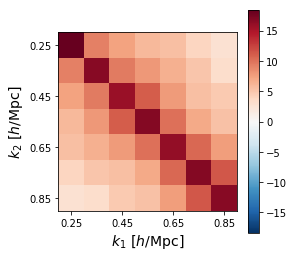

In [986]:
mat=(qpm_cov*k_mat)[2:nk,2:nk]
vmax = np.percentile(mat.ravel(),99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r);plt.colorbar();
vals = np.linspace(0,nk-3,4,dtype='int')
plt.xticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.yticks(vals,["%.2f"%k_bins[v+1] for v in vals])
plt.gca().xaxis.tick_bottom();
plt.xlabel(r'$k_1\,\,[h/\mathrm{Mpc}]$',fontsize=14)
plt.ylabel(r'$k_2\,\,[h/\mathrm{Mpc}]$',fontsize=14);

### Visualize for all $\ell$

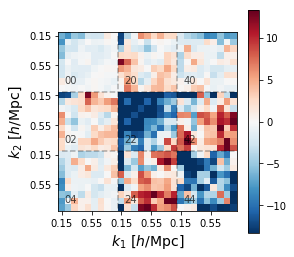

In [987]:
k_plotter(k_mat*(gaussian_tot(alpha50_opt)-qpm_cov),99.)

### Plot diagonals

R0=50: Full Lines, R0=100: Dashed Lines


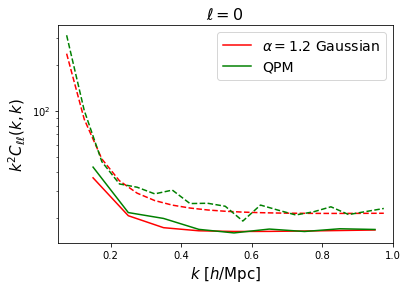

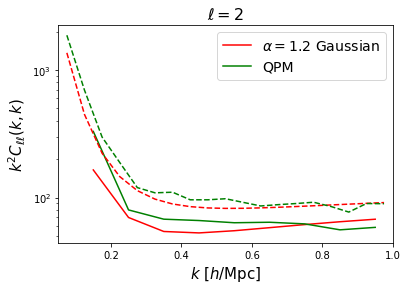

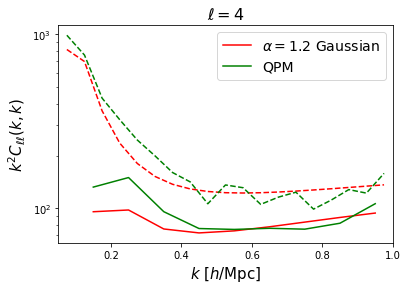

In [988]:
for i in range(m):
    plt.figure()
    plt.plot(k_bins,np.diag(k_mat*gaussian_tot(alpha50_opt)).reshape(m,n).T[:,i],label=r'$\alpha = 1.2$ Gaussian',c='r')
    plt.plot(k_bins,np.diag(k_mat*qpm_cov).reshape(m,n).T[:,i],label='QPM',c='g');
    plt.plot(k100,np.diag(k_mat100*gaussian_tot100(alpha100_opt)).reshape(m,n100).T[:,i],c='r',ls='--')
    plt.plot(k100,np.diag(k_mat100*qpm_cov100).reshape(m,n100).T[:,i],c='g',ls='--');
    plt.yscale('log')
    plt.xlim([0.05,1.])
    plt.legend(fontsize=14);
    plt.xlabel(r'$k\,\,[h/\mathrm{Mpc}]$',fontsize=15)
    plt.ylabel(r'$k^2C_{\ell\ell}(k,k)$',fontsize=15)
    plt.title(r'$\ell = %d$'%(i*2),fontsize=16)
print("R0=50: Full Lines, R0=100: Dashed Lines")

## Consider idealized covariance

In [714]:
gal_file = np.loadtxt('/mnt/store1/oliverphilcox/PowerSpectra/qpm_galaxy_1.xyzwj')

gal_w = gal_file[:,3]
# compute mean n from FKP weights
nbar = np.mean(1./gal_w-1)/20000
gal_n = (1./gal_w-1)/20000

In [715]:
V=len(gal_w)/nbar
k100_all = np.asarray([k100 for _ in range(m)]).ravel()

In [724]:
V_effs=[]
for i in range(len(k100_all)):
    V_effs.append(np.sum((power100.T.ravel()[i]**2*gal_n+1)**2/(power100.T.ravel()[i]**2*gal_n**3))/len(gal_n))

In [725]:
delta_k = k100[-1]-k100[-2]
ideal_cov100=np.diag((2.*np.pi)**3*(power100.T.ravel())**2/(2.*np.pi*k100_all**2*delta_k)/V_effs[i])

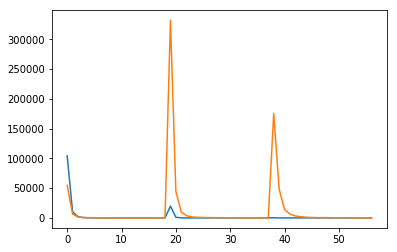

In [726]:
plt.plot(np.diag(ideal_cov100))
plt.plot(np.diag(qpm_cov100))

## Look at ratio of covariances with same $k$-binning

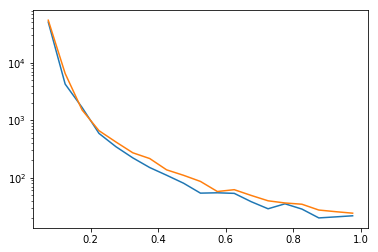

In [753]:
plt.plot(k100,np.diag(qpm_cov50f).T.reshape(m,nk100)[0])
plt.plot(k100,np.diag(qpm_cov100).T.reshape(m,nk100)[0])
plt.yscale('log')

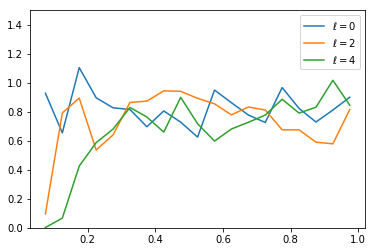

In [757]:
qpm_cov50f = np.load('R0_50_cov_0.05.npy')
for i in range(m):
    plt.plot(k100,(np.diag(qpm_cov50f)/np.diag(qpm_cov100))[i*nk100:(i+1)*nk100],label=r'$\ell = %d$'%(i*2))
plt.legend();
plt.ylim([0,1.5]);

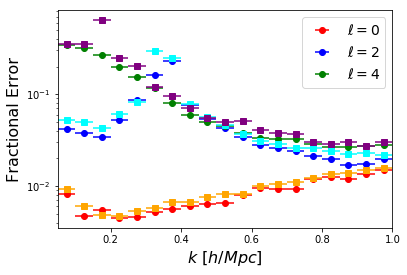

In [776]:
qpm_std50f = np.sqrt(np.diag(qpm_cov50f)).reshape(m,nk100).T
power50f = np.load('R0_50_power_0.05.npy')
xf=np.abs(qpm_std50f/power50f)
x100=np.abs(qpm_std100/power100)
plt.errorbar(k100,xf[:,0],None,0.025,c='r',label=r'$\ell = 0$',ls='',marker='o')
plt.errorbar(k100,xf[:,1],None,0.025,c='b',label=r'$\ell = 2$',ls='',marker='o')
plt.errorbar(k100,xf[:,2],None,0.025,c='g',label=r'$\ell = 4$',ls='',marker='o')
plt.errorbar(k100,x100[:,0],None,0.025,ls='',marker='s',c='orange')
plt.errorbar(k100,x100[:,1],None,0.025,ls='',marker='s',c='cyan')
plt.errorbar(k100,x100[:,2],None,0.025,ls='',marker='s',c='purple')
plt.yscale('log');
plt.xlim([0.05,1.])
plt.legend(fontsize=14);
plt.ylabel('Fractional Error',fontsize=16);
plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16);

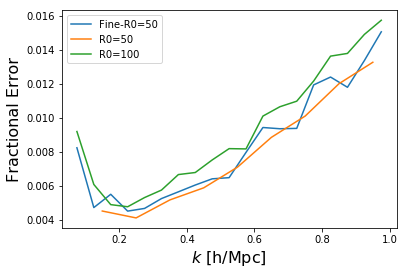

In [804]:
#plt.plot(qpm_std50f/qpm_std100)
plt.errorbar(k100,xf[:,0],label='Fine-R0=50')
plt.errorbar(k_bins,x[:,0],label='R0=50')
plt.errorbar(k100,x100[:,0],label='R0=100')
plt.legend();plt.ylabel(r'Fractional Error',fontsize=16);
plt.xlabel(r'$k$ [h/Mpc]',fontsize=16);

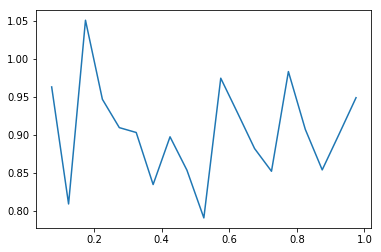

In [820]:
plt.plot(k100,(qpm_std50f/qpm_std100)[:,0])

# Scratch

In [269]:
power_model=np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_power.npz')
kh = power_model['k']
pk = power_model['pow'][0]

## First fit power spectrum to spline
from scipy.interpolate import UnivariateSpline
spl2 = UnivariateSpline(np.log(kh),np.log(pk[:]),s=1)
def linear_power_model(k):
    return np.exp(spl2(np.log(k)))

def kaiser_power_model(k,ell):
    """ Kaiser linear power model from https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf"""
    f = 0.774 # kaiser power
    b = 2 # bias
    lin_pow = linear_power_model(k)
    beta = f/b
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")

In [321]:
power_ravel = np.asarray([pp.T.reshape(-1,) for pp in all_power])

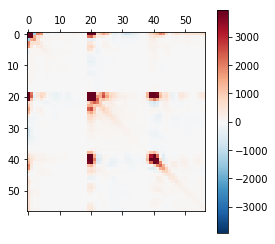

In [322]:
mat=np.cov(power_ravel.T)
vmax=np.percentile(mat,99.)
plt.matshow(mat,vmax=vmax,vmin=-vmax,cmap=cm.RdBu_r)
plt.colorbar();

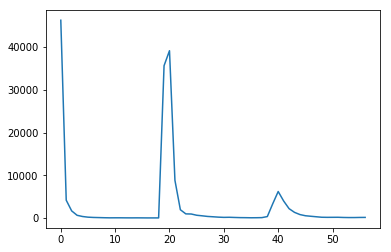

In [119]:
plt.plot(np.diag(mat));#plt.yscale('log');

In [118]:
theory_cov=np.load('theory_power_cov.npy')

In [61]:
plt.matshow(inv_theory);plt.colorbar()

NameError: name 'inv_theory' is not defined

In [803]:
inv_theory = np.linalg.inv(theory_cov)
sq_inv_th = np.linalg.cholesky(inv_theory)
disc = np.matmul(sq_inv_th.T,np.matmul(cov,sq_inv_th))

LinAlgError: Matrix is not positive definite

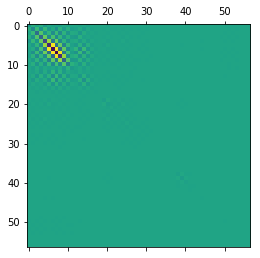

In [801]:
plt.matshow(inv_theory*mat)

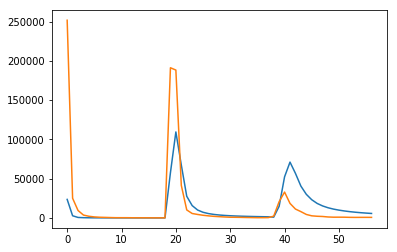

In [798]:
plt.plot(np.diag(theory_cov))
plt.plot(np.diag(mat)*5)

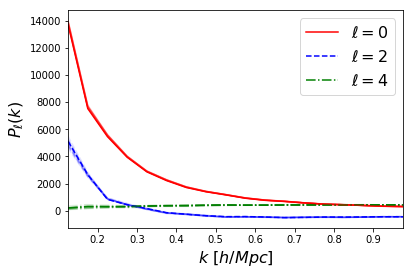

In [105]:
for i in range(n_mocks):
    if i==0:
        plt.plot(k_bins,all_power[i][:,0],label=r'$\ell=0$',c='r',ls='-')
        plt.plot(k_bins,all_power[i][:,1],label=r'$\ell=2$',c='b',ls='--')
        plt.plot(k_bins,all_power[i][:,2],label=r'$\ell=4$',c='g',ls='-.')
    else:
        plt.plot(k_bins,all_power[i][:,0],c='r',ls='-',alpha=0.1)
        plt.plot(k_bins,all_power[i][:,1],c='b',ls='--',alpha=0.1)
        plt.plot(k_bins,all_power[i][:,2],c='g',ls='-.',alpha=0.1)
plt.legend(fontsize=16);
plt.ylabel(r'$P_\ell(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/Mpc]$',fontsize=16)
plt.xlim([0.125,0.975]);

In [93]:
all_power[0][0]

array([13715.95492505,  5109.8731135 ,   206.8363445 ])

In [26]:
power_estimate = (DD-2.*DR/(DR_pairs/DD_pairs)+RR/(RR_pairs/DD_pairs))/norm

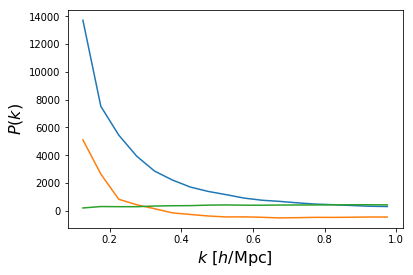

In [285]:
#plt.plot(k_bins,power_estimate)
plt.plot(k_bins,binned_power_estimate.reshape(-1,3))
#plt.yscale('log')
plt.ylabel(r'$P(k)$',fontsize=16);plt.xlabel(r'$k\,\,[h/$Mpc]',fontsize=16);

**Add simple CAMB model for comparison**

In [62]:
power_model=np.load('/mnt/store1/oliverphilcox/PowerSpectra/linear_kaiser_power.npz')
kh = power_model['k']
pk = power_model['pow'][0]

## First fit power spectrum to spline
from scipy.interpolate import UnivariateSpline
spl = UnivariateSpline(np.log(kh),np.log(pk[:]),s=1)
def linear_power_model(k):
    return np.exp(spl(np.log(k)))

def kaiser_power_model(k,ell):
    """ Kaiser linear power model from https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf"""
    f = 0.774 # jaiser power
    b = 2 # bias
    lin_pow = linear_power_model(k)
    beta = f/b
    if ell==0:
        return (1.+2./3.*beta+1./5.*beta**2.)*b**2.*lin_pow
    elif ell==2:
        return (4./3.*beta+4./7.*beta**2.)*b**2.*lin_pow
    elif ell==4:
        return 8./45.*beta**2.*b**2.*lin_pow
    else:
        raise Exception("Only ell = 0,2,4 in linear model")

In [63]:
from scipy.integrate import quad

ell=0

#binned_power = []
true_binned_power = []
true_point_power = []

for i in range(len(all_k)):
    #binned_power.append(quad(lambda k: kaiser_power_model(k,2)*k,all_k[i,0],all_k[i,1])[0]/quad(lambda k: k,k_bins[i,0],k_bins[i,1])[0])
    true_binned_power.append(quad(lambda k: kaiser_power_model(k,0)*k**2.,all_k[i,0],all_k[i,1])[0]/quad(lambda k: k**2.,all_k[i,0],all_k[i,1])[0])
    true_point_power.append(kaiser_power_model(np.mean([all_k[i,0],all_k[i,1]]),0))

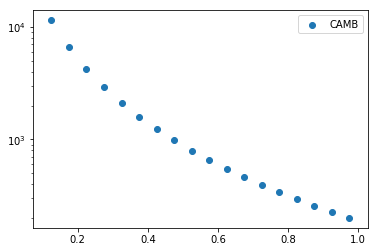

In [72]:
kk = np.mean(all_k,axis=1)
plt.scatter(kk,power_estimate,label='RascalC')
plt.scatter(kk,true_point_power,label='CAMB');
plt.legend();plt.yscale('log');

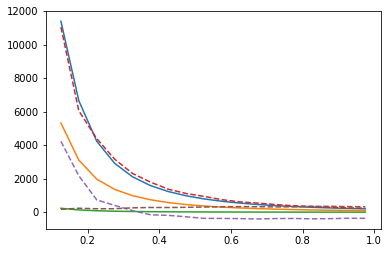

In [78]:
for ell in [0,2,4]:
    plt.plot(kk,[kaiser_power_model(k,ell) for k in kk])
plt.plot(kk,power_estimate.reshape(-1,3)*0.8,ls='--')

#### Compare binned vs unbinned

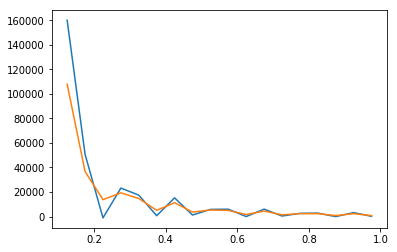

In [105]:
plt.plot(k_bins,DD)
plt.plot(k_bins,DD_binned)

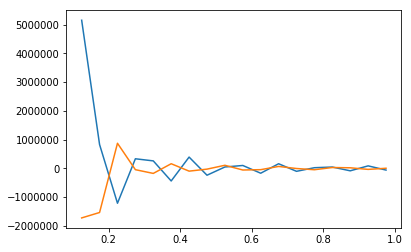

In [107]:
plt.plot(k_bins,DR)
plt.plot(k_bins,DR_binned)